In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import impnb
import Data_processing as dp
import ToyQ2
from scipy.optimize import minimize
from functools import partial

behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
Logs=pd.read_pickle(behavior_log_path+'new_rat26to38.pkl')

In [6]:
def myllNEG(action_log,reward_log,params):
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    Q=np.zeros((n,2))
    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
        ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
        -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return -np.sum(ll,axis=0)

def myll_log(action_log,reward_log,params):
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    Q=np.zeros((n,2))
    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
        ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
        -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return ll,PE,q,Q

def MLE(action_log,reward_log,params0):
    b1=(0.05,1)
    b2=(1,40)
    bnds=(b1,b1,b2)
    cur_myll=partial(myllNEG,mya,myr)
    sol=minimize(cur_myll,params0,method='SLSQP',bounds=bnds)
    return sol

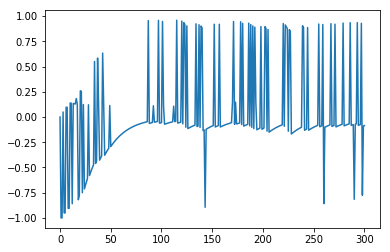

In [7]:
real_params=[0.05,0.02,4]
env=ToyQ2.toyQ_2choice()
rat1=dp.Rat(None,*real_params,init_Q=np.array([0.000001,0.00001]),sim=True)
env,rat1=dp.train_rat(env,rat1,300,sim=True)
plt.plot(rat1.PElog)
mya=rat1.choice_Log
myr=rat1.obsLog

In [8]:
params0

[0.450942, 0.466634, 0.553753]

In [9]:
sol=MLE(mya,myr,real_params)
sol

     fun: 311.0841531148998
     jac: array([ 55.24338531,   0.        , 118.95992279])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 3
    njev: 2
  status: 0
 success: True
       x: array([0.05000001, 0.05      , 1.        ])

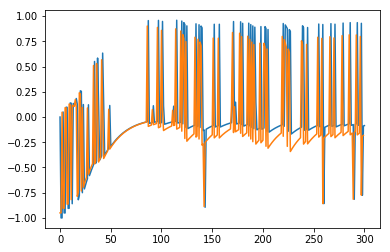

In [10]:
mparams=sol['x']
ll,PE,q,Q=myll_log(mya,myr,mparams)
plt.plot(rat1.PElog)
plt.plot(PE)

# Get all PE logs

In [11]:
Logs[26]['action'][0];

38 0


IndexError: index 278 is out of bounds for axis 0 with size 278

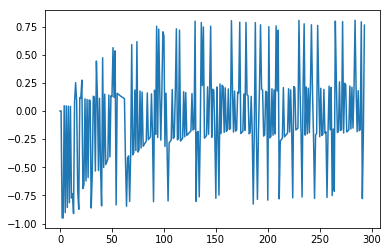

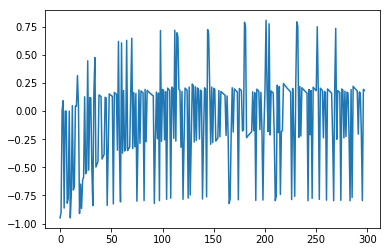

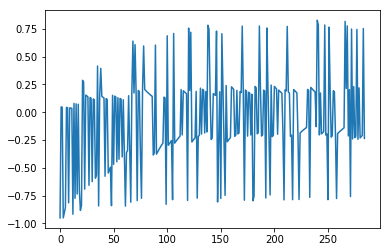

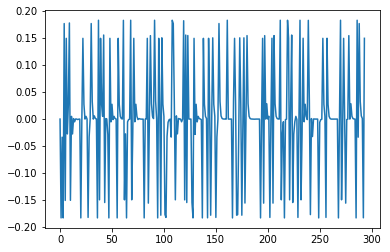

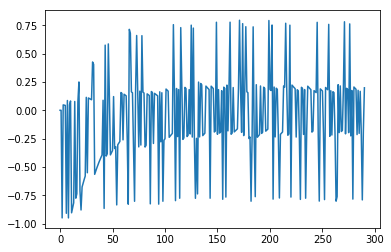

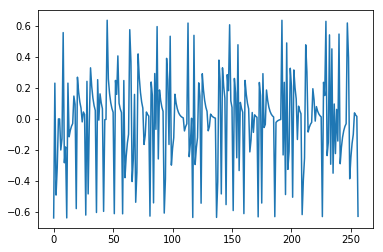

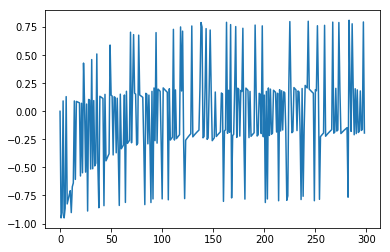

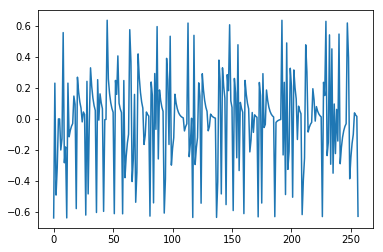

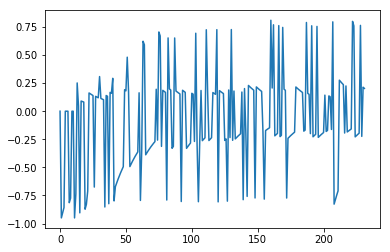

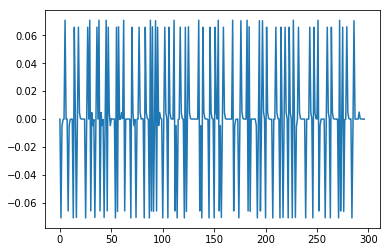

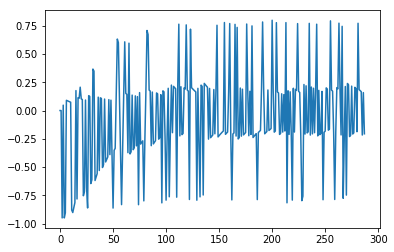

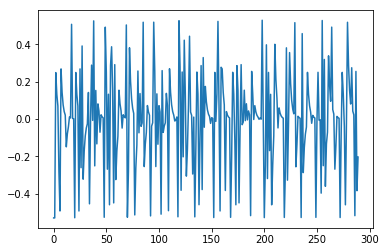

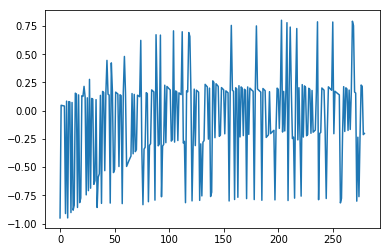

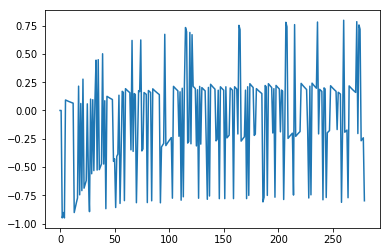

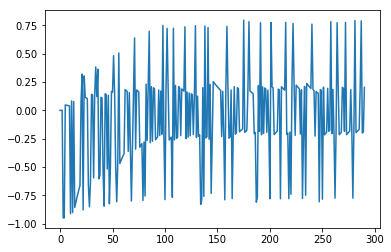

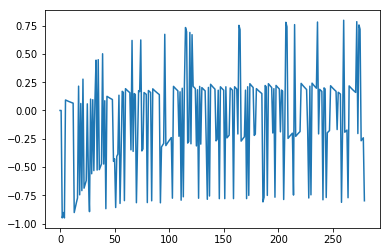

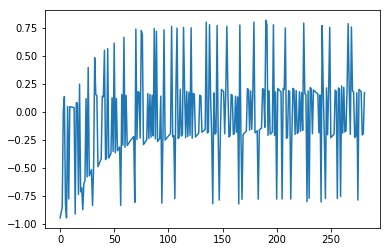

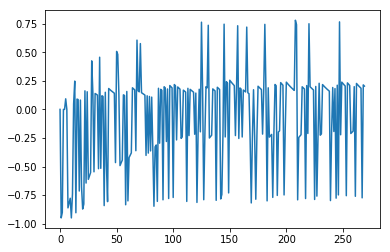

<Figure size 432x288 with 0 Axes>

In [12]:
count=1
PELogs={}
for i in Logs:
    params0=[0.450942, 0.466634, 0.553753]
    days=len(Logs[i]['action'])
    for day in range(days):
        plt.figure(count)
        count+=1
        mya=Logs[i]['action'][day]
        myr=Logs[i]['reward'][day]
        if (len(mya)!=len(myr)):
            print(i,day)
        sol=MLE(mya,myr,real_params)
        mparams=sol['x']
        ll,PE,q,Q=myll_log(mya,myr,mparams)
        plt.plot(PE)
        PELogs['rat_'+str(i)+'day_'+str(day)]=PE

In [31]:
PElog_df=pd.Series(PELogs).to_frame('ColumnName')
PElog_df.to_pickle(behavior_log_path+'rat26to38PElog.pkl')